In [1]:
# pip install hvplot

In [2]:
# Dependencies
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# import hvplot.pandas as hvplot
import plotly as plt
import plotly.express as px


pd.set_option("max_rows", None)

In [3]:
# Read in candidates data
df1 = pd.read_csv("candidates_clean_st.csv")
df_cand = df1.copy()
df_cand.head()

,unique_key,id,cycle,fec_cand_id,cid,first_last_party,party,dist_id_run_for,dist_id_currently_held,current_candidate,cycle_candidate,crpico,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,state,result
0,1996N00000948,56756,1996,P80001118,N00000948,Lenora B Fulani (3),3,PRES,,,,C,3L,,0.0,6000.0,6000,0.0,PR,L
1,1996N00004451,58068,1996,S6MN00143,N00004451,Stephen Bonsal Young (R),R,MNS1,,,Y,C,RL,,492.0,97408.0,264254,166354.0,MN,L
2,1996N00001670,57382,1996,S6DE00073,N00001670,Raymond J Clatworthy (R),R,DES2,,Y,Y,C,RL,,202815.0,618935.0,1636414,814664.0,DE,L
3,1996N00000525,57290,1996,S4VT00066,N00000525,Gavin Terence Mills (I),U,VTS1,,,,C,3L,,0.0,266.0,266,0.0,VT,L
4,1996N00005551,53386,1996,H2OK05045,N00005551,Ernest J Istook (R),R,OK05,OK05,Y,Y,I,RW,,130384.0,99600.0,399980,169996.0,OK,W


In [4]:
# Read in PAC data 
# df2 = pd.read_csv("pacs.csv", on_bad_lines='skip')
# df_pac = df2.copy()
# df_pac.head()

# Cleaned
# df2 = pd.read_csv('pacs_clean.csv')
# df_pac = df2.copy()
# df_pac.head()

## <font color = 'gold'>Clean

In [5]:
# Handle nulls
# df_pac.isnull().sum()

In [6]:
# df_pac = df_pac.dropna()

In [7]:
# df_pac.duplicated().sum()

In [8]:
# Drop duplicates
# df_pac = df_pac.drop_duplicates()

In [9]:
# df_pac.to_csv('pacs_clean.csv')

In [10]:
# # Join pac and candidates dfs
# df_paccand = df_cand.merge(df_pac, how='left', on='cid')
# df_paccand.head()

## <font color = 'gold'>Explore Features

In [11]:
# See if cycle_candidate is significant
# if there are W and blank c_c, then it's significant
# if there L for every blank c_c, insignificant - drop
# df3 = df_cand[(df_cand['cycle_candidate'] == ' ') & (df_cand['result'] == 'W')]
# df3.head(10)

# KEEP for now, but test both ways.

In [12]:
# Choose columns for features
columns = ['party', 'crpico', 'raised_from_pacs', 'raised_from_individuals',	'raised_total',	'raised_unitemized', 'result']

# # consider dropping later:
#   #cycle_candidate
#   #nopacs
#   #dist_id_currently_held

df_features = df_cand[columns]
df_features.head()

,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result
0,3,C,0.0,6000.0,6000,0.0,L
1,R,C,492.0,97408.0,264254,166354.0,L
2,R,C,202815.0,618935.0,1636414,814664.0,L
3,U,C,0.0,266.0,266,0.0,L
4,R,I,130384.0,99600.0,399980,169996.0,W


In [13]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19863 entries, 0 to 19862
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   party                    19863 non-null  object 
 1   crpico                   19863 non-null  object 
 2   raised_from_pacs         19863 non-null  float64
 3   raised_from_individuals  19863 non-null  float64
 4   raised_total             19863 non-null  int64  
 5   raised_unitemized        19863 non-null  float64
 6   result                   19863 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.1+ MB


In [14]:
df_features.nunique()

party                          4
crpico                         5
raised_from_pacs           11607
raised_from_individuals    15530
raised_total               17987
raised_unitemized          14653
result                         2
dtype: int64

In [15]:
# df_features = df_features[df_features['party'].isin(['R','D'])]

In [16]:
df_features.party.value_counts()

R    9746
D    8779
U     786
3     552
Name: party, dtype: int64

## <font color = 'gold'>Preprocessing
### Categorical Variables
#### <font color = 'skyblue'>Bucket

In [17]:
for col in df_features.columns:
  print(df_features[col][0:2].value_counts())

# drop nopacs, bucket crpico 

3    1
R    1
Name: party, dtype: int64
C    2
Name: crpico, dtype: int64
0.0      1
492.0    1
Name: raised_from_pacs, dtype: int64
6000.0     1
97408.0    1
Name: raised_from_individuals, dtype: int64
6000      1
264254    1
Name: raised_total, dtype: int64
0.0         1
166354.0    1
Name: raised_unitemized, dtype: int64
L    2
Name: result, dtype: int64


In [18]:
# state_1 = list(df_features.state.value_counts().index)

In [19]:
# get value counts variable
crpico_type = df_features['crpico'].value_counts()
crpico_type

C    9506
I    5675
O    4596
       85
3       1
Name: crpico, dtype: int64

In [20]:
# Determine which values to replace if counts are less than 100?
replace_crpico = list(crpico_type[crpico_type < 100].index)

# Replace in dataframe
for cls in replace_crpico:
    df_features.crpico = df_features.crpico.replace(cls,"Other")
    
# Check to make sure binning was successful
df_features.crpico.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


C        9506
I        5675
O        4596
Other      86
Name: crpico, dtype: int64

In [21]:
# encode W/L of 'result' column by mapping
x = {'W': 1, 'L': 0}
df_features = df_features.replace(x)
df_features.head()

,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result
0,3,C,0.0,6000.0,6000,0.0,0
1,R,C,492.0,97408.0,264254,166354.0,0
2,R,C,202815.0,618935.0,1636414,814664.0,0
3,U,C,0.0,266.0,266,0.0,0
4,R,I,130384.0,99600.0,399980,169996.0,1


In [22]:
df_features.nunique()

party                          4
crpico                         4
raised_from_pacs           11607
raised_from_individuals    15530
raised_total               17987
raised_unitemized          14653
result                         2
dtype: int64

In [23]:
# # get value counts variable
# party_type = df_features['party'].value_counts()
# party_type

# # Determine which values to replace if counts are less than 100?
# rep_party = list(party_type[party_type < 1000].index)

# # Replace in dataframe
# for cls in rep_party:
#     df_features.party = df_features.party.replace(cls,"Other")
    
# # Check to make sure binning was successful
# df_features.party.value_counts()

#### <font color = 'skyblue'>Encode

In [24]:
# # Encode State with label encoder ###############
# le = LabelEncoder()
# df_features['state'] = le.fit_transform(df_features['state'])

In [25]:
# generate categorical variable list
catvars = df_features.dtypes[df_features.dtypes == 'object'].index
catvars

Index(['party', 'crpico'], dtype='object')

In [26]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df_features[catvars]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(catvars)
encode_df.head()

,party_3,party_D,party_R,party_U,crpico_C,crpico_I,crpico_O,crpico_Other
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [27]:
# Merge one-hot encoded features and drop the originals
encoded_df = df_features.merge(encode_df, left_index=True, right_index=True)
encoded_df = encoded_df.drop(catvars, axis=1)
encoded_df.head()

,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result,party_3,party_D,party_R,party_U,crpico_C,crpico_I,crpico_O,crpico_Other
0,0.0,6000.0,6000,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,492.0,97408.0,264254,166354.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,202815.0,618935.0,1636414,814664.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,266.0,266,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,130384.0,99600.0,399980,169996.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [28]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19863 entries, 0 to 19862
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   raised_from_pacs         19863 non-null  float64
 1   raised_from_individuals  19863 non-null  float64
 2   raised_total             19863 non-null  int64  
 3   raised_unitemized        19863 non-null  float64
 4   result                   19863 non-null  int64  
 5   party_3                  19863 non-null  float64
 6   party_D                  19863 non-null  float64
 7   party_R                  19863 non-null  float64
 8   party_U                  19863 non-null  float64
 9   crpico_C                 19863 non-null  float64
 10  crpico_I                 19863 non-null  float64
 11  crpico_O                 19863 non-null  float64
 12  crpico_Other             19863 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 2.0 MB


#### <font color= 'skyblue'>Create Features and Target Arrays

In [29]:
# Split preprocessed data into features and target arrays
y = encoded_df.result.values
X = encoded_df.drop('result', axis=1).values

<font color= 'skyblue'>Split to Training and Testing data

In [30]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

<font color= 'skyblue'>Standard Scale

In [31]:
# Scale / Standardize feature data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# view data to ensure successful standardization
X_train_scaled[:1]

array([[-0.18178743, -0.05320403, -0.09423217, -0.1393625 , -0.16844056,
         1.12810298, -0.98779018, -0.20018842, -0.95798718, -0.63044997,
         1.81536757, -0.06516901]])

## <font color='gold'>Model - Random Forest Classifier

In [32]:
# Resample the training data with the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=43)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=43)

In [33]:
# Calculate the accuracy score
y_true = y_test
y_pred = clf.predict(X_test_scaled)
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")
print("\n---------------------------------------------------------------------------------\n")


# Display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Lose", "Win"], columns=["Predicted Lose", "Predicted Win"])
print(cm_df)
print("\n---------------------------------------------------------------------------------\n")

# Print the imbalanced classification report
print(classification_report(y_true, y_pred))

Accuracy Score: 0.9349577124446234

---------------------------------------------------------------------------------

      Predicted Lose  Predicted Win
Lose            3178            177
Win              146           1465

---------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3355
           1       0.89      0.91      0.90      1611

    accuracy                           0.93      4966
   macro avg       0.92      0.93      0.93      4966
weighted avg       0.94      0.93      0.94      4966



## <font color='gold'>KMeans Clustering

In [34]:
# Initialize df from copy
df_clust = df1.copy()
df_clust.head()

,unique_key,id,cycle,fec_cand_id,cid,first_last_party,party,dist_id_run_for,dist_id_currently_held,current_candidate,cycle_candidate,crpico,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,state,result
0,1996N00000948,56756,1996,P80001118,N00000948,Lenora B Fulani (3),3,PRES,,,,C,3L,,0.0,6000.0,6000,0.0,PR,L
1,1996N00004451,58068,1996,S6MN00143,N00004451,Stephen Bonsal Young (R),R,MNS1,,,Y,C,RL,,492.0,97408.0,264254,166354.0,MN,L
2,1996N00001670,57382,1996,S6DE00073,N00001670,Raymond J Clatworthy (R),R,DES2,,Y,Y,C,RL,,202815.0,618935.0,1636414,814664.0,DE,L
3,1996N00000525,57290,1996,S4VT00066,N00000525,Gavin Terence Mills (I),U,VTS1,,,,C,3L,,0.0,266.0,266,0.0,VT,L
4,1996N00005551,53386,1996,H2OK05045,N00005551,Ernest J Istook (R),R,OK05,OK05,Y,Y,I,RW,,130384.0,99600.0,399980,169996.0,OK,W


In [35]:
# isolate first_last_
name = pd.DataFrame(df_clust.first_last_party)
name.head()

,first_last_party
0,Lenora B Fulani (3)
1,Stephen Bonsal Young (R)
2,Raymond J Clatworthy (R)
3,Gavin Terence Mills (I)
4,Ernest J Istook (R)


In [36]:
# Choose features
df_clust = df_clust[['party', 'state', 'crpico', 'raised_from_pacs',	'raised_from_individuals', 'raised_unitemized']]
df_clust.head()

,party,state,crpico,raised_from_pacs,raised_from_individuals,raised_unitemized
0,3,PR,C,0.0,6000.0,0.0
1,R,MN,C,492.0,97408.0,166354.0
2,R,DE,C,202815.0,618935.0,814664.0
3,U,VT,C,0.0,266.0,0.0
4,R,OK,I,130384.0,99600.0,169996.0


In [37]:
# encode cat variables
X = pd.get_dummies(df_clust, columns=['party','state','crpico'])
X.head()

,raised_from_pacs,raised_from_individuals,raised_unitemized,party_3,party_D,party_R,party_U,state_AK,state_AL,state_AR,...,state_VT,state_WA,state_WI,state_WV,state_WY,crpico_,crpico_3,crpico_C,crpico_I,crpico_O
0,0.0,6000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,492.0,97408.0,166354.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,202815.0,618935.0,814664.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.0,266.0,0.0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,130384.0,99600.0,169996.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [38]:
# Standardize data
X_scaled = StandardScaler().fit_transform(X)
X_scaled[0:1]

array([[-1.96995688e-01, -8.95969907e-02, -1.04459677e-01,
         5.91470165e+00, -8.89967743e-01, -9.81493276e-01,
        -2.02981395e-01, -6.59430483e-02, -1.26120185e-01,
        -1.05342163e-01, -3.54994040e-02, -1.43359047e-01,
        -3.52561401e-01, -1.26941642e-01, -1.09890026e-01,
        -3.62033432e-02, -6.03159787e-02, -2.27323021e-01,
        -1.74659201e-01, -3.09429839e-02, -8.51558647e-02,
        -1.11057301e-01, -7.95799083e-02, -2.06849327e-01,
        -1.57029427e-01, -1.03121131e-01, -1.16060652e-01,
        -1.19574729e-01, -1.43724382e-01, -1.48575619e-01,
        -8.98299924e-02, -1.77847663e-01, -1.39094298e-01,
        -1.51383226e-01, -1.22905412e-02, -1.04113854e-01,
        -6.78414927e-02, -1.73584933e-01, -5.36462094e-02,
        -8.89717312e-02, -9.09621442e-02, -1.63474373e-01,
        -9.56292184e-02, -9.37346568e-02, -2.27690206e-01,
        -1.97128975e-01, -1.22571457e-01, -1.20007150e-01,
        -2.03786710e-01,  1.00170773e+01, -7.66440475e-0

### PCA

In [39]:
# Reduce dimensions using PCA
pca = PCA(n_components=3)
cand_pca = pca.fit_transform(X_scaled)

In [40]:
# Create a DataFrame with the three principal components.
pca_df = pd.DataFrame(data=cand_pca, columns=["PC 1", "PC 2", "PC 3"], index=df_clust.index)
pca_df.head(10)

,PC 1,PC 2,PC 3
0,1.565117,0.955164,4.515286
1,-0.646670,1.406485,1.224566
2,-0.246360,1.561403,0.643854
3,-0.959880,0.608175,2.893034
4,0.164547,0.889973,-1.844727
5,-0.667200,1.426067,0.604072
6,-0.705433,1.604543,0.696799
7,-0.354359,0.224926,0.290393
8,-0.174922,1.374292,-1.381523
9,-0.374030,-1.241774,1.218558


### Elbow Curve

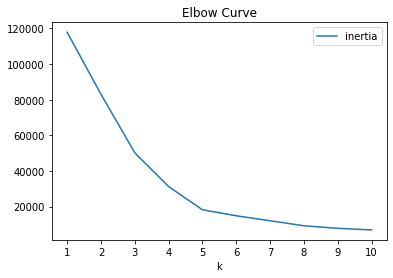

In [41]:
# Create an Elbow Curve to find the best value for K.

inertia = []
k = list(range(1,11))

# Get / store inertia values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)
    
# Define DF to plot Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.plot(kind='line', x='k', y='inertia', title="Elbow Curve", xticks=k)

Clustering

In [42]:
# Initialize the K-Means model.
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predicts = model.predict(pca_df)

In [43]:
# Create a new DataFrame including predicted clusters and candidate features.
# Concatentate the df_clust and pcs_df DataFrames on the same columns.
clustered_df = df_clust.join(pca_df, how='inner')

#  Add a new column, "CoinName" to the clustered_df DataFrame that holds the names of the cryptocurrencies. 
clustered_df = clustered_df.join(name, how='inner')

#  Add a new column, "Class" to the clustered_df DataFrame that holds the predictions.
clustered_df['Class'] = model.labels_

# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)

(19863, 11)


,party,state,crpico,raised_from_pacs,raised_from_individuals,raised_unitemized,PC 1,PC 2,PC 3,first_last_party,Class
0,3,PR,C,0.0,6000.0,0.0,1.565117,0.955164,4.515286,Lenora B Fulani (3),4
1,R,MN,C,492.0,97408.0,166354.0,-0.646670,1.406485,1.224566,Stephen Bonsal Young (R),0
2,R,DE,C,202815.0,618935.0,814664.0,-0.246360,1.561403,0.643854,Raymond J Clatworthy (R),0
3,U,VT,C,0.0,266.0,0.0,-0.959880,0.608175,2.893034,Gavin Terence Mills (I),4
4,R,OK,I,130384.0,99600.0,169996.0,0.164547,0.889973,-1.844727,Ernest J Istook (R),2
5,R,MI,C,0.0,5576.0,12474.0,-0.667200,1.426067,0.604072,Stephen Wayne Hofman (R),0
6,R,TX,C,2000.0,72177.0,110748.0,-0.705433,1.604543,0.696799,Olivia Coggin Eudaly (R),0
7,U,FL,O,0.0,3436.0,1946.0,-0.354359,0.224926,0.290393,H Harold Hardee (I),0
8,R,FL,O,500.0,40500.0,61320.0,-0.174922,1.374292,-1.381523,Joseph Dr Smith (R),2
9,D,MI,C,0.0,42841.0,35855.0,-0.374030,-1.241774,1.218558,Godfrey J Dillard (D),4


In [44]:
clustered_df.groupby('Class')['Class'].count()

Class
0    4948
1    4872
2    5047
3       8
4    4988
Name: Class, dtype: int64

In [45]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="Class",
    symbol="Class",
    hover_name="first_last_party",
    hover_data=["crpico"],
    width=800
)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

## <font color='gold'>2022 Predictions

In [48]:
df3 = pd.read_csv('cand_summary_2022_clean.csv')
df_2022 = df3.copy()
df_2022.fillna('',inplace=True)
print(df_2022.party.value_counts())
# df_2022 = df_2022[df_2022['raised_total'] > 0]
df_2022 = df_2022.reset_index().drop('index', axis=1)
df_2022.head()

R    2098
D    1541
3     690
Name: party, dtype: int64


,first_last_party,Cand_Office_St,Cand_Office,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
0,"GODFREY, MARCUS SCOTT",CA,House,3,C,0.0,0.0,0.0,0.0
1,"NICHOLAS CRANE, STRAUSS",MO,Senate,3,O,0.0,0.0,0.0,0.0
2,"PINNEY, DWAYNE",FL,Senate,R,C,0.0,0.0,0.0,0.0
3,"DEHART, VAUGHAN BRANDON BRENDAN",AZ,House,R,C,0.0,0.0,0.0,0.0
4,"NEUBERT, KEITH",WI,Senate,R,C,0.0,0.0,0.0,0.0


In [49]:
features_2022 = df_2022.drop(['first_last_party','Cand_Office_St', 'Cand_Office'], axis=1)

In [50]:
cols = list(features_2022.columns)
new_cols = list((cols[1], cols[0]))
new_cols = new_cols + cols[2:]
features_2022 = features_2022[new_cols]
features_2022 = features_2022.reset_index().drop('index', axis=1)
features_2022.head()

,crpico,party,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
0,C,3,0.0,0.0,0.0,0.0
1,O,3,0.0,0.0,0.0,0.0
2,C,R,0.0,0.0,0.0,0.0
3,C,R,0.0,0.0,0.0,0.0
4,C,R,0.0,0.0,0.0,0.0


In [51]:
##### Explore why States don't match up in both DFs
features_2022.nunique()

crpico                        4
party                         3
raised_from_pacs           1476
raised_from_individuals    2127
raised_total               2451
raised_unitemized          2226
dtype: int64

In [52]:
# features_2022 = features_2022[features_2022['party'].isin(['R','D'])]

In [53]:
features_2022.party.value_counts()

R    2098
D    1541
3     690
Name: party, dtype: int64

In [54]:
features_2022.crpico = features_2022.crpico.replace('','Other')

In [55]:
features_2022.crpico.value_counts()

C        2848
O         943
I         411
Other     127
Name: crpico, dtype: int64

In [56]:
# diff = []
# state_1
# state_2 = list(features_2022.Cand_Office_St.value_counts().index)
# for i in state_2:
#   if i in state_1:
#     continue
#   else:
#     diff.append(i)
# diff

In [57]:
# print(state_1)
# print(state_2)

In [58]:
# features_2022_us = features_2022[features_2022['Cand_Office_St'] == 'US']
# features_2022_us.raised_total.value_counts()

In [59]:
# features_2022 = features_2022[features_2022['Cand_Office_St'] != 'US']

#### <font color='skyblue'>Encode

In [60]:
# # Encode State with label encoder ###############
# le = LabelEncoder()
# features_2022['Cand_Office_St'] = le.fit_transform(features_2022['Cand_Office_St'])

In [61]:
# generate categorical variable list
catvars = features_2022.dtypes[features_2022.dtypes == 'object'].index
catvars

Index(['crpico', 'party'], dtype='object')

In [62]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(features_2022[catvars]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(catvars)
encode_df['party_U'] = 0.0
encode_df = encode_df[['party_3',	'party_D',	'party_R', 'party_U', 'crpico_C',	'crpico_I',	'crpico_O',	'crpico_Other']]
encode_df.head()

,party_3,party_D,party_R,party_U,crpico_C,crpico_I,crpico_O,crpico_Other
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [63]:
# Merge one-hot encoded features and drop the originals
encoded_df = features_2022.merge(encode_df, left_index=True, right_index=True)
encoded_df = encoded_df.drop(catvars, axis=1)
encoded_df.head()

,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,party_3,party_D,party_R,party_U,crpico_C,crpico_I,crpico_O,crpico_Other
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [64]:
# Split preprocessed data into features
X = encoded_df.values

In [65]:
# Scale / Standardize feature data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# view data to ensure successful standardization
X_scaled[:1]

array([[-0.27555788, -0.21477757, -0.20204877, -0.11577786,  2.29650017,
        -0.74345542, -0.96973475,  0.        ,  0.72111999, -0.3238834 ,
        -0.52773071, -0.17384966]])

In [66]:
# Predict 2022 election Results
predictions_2022 = clf.predict(X_scaled)

In [67]:
preds = pd.Series(predictions_2022, name='preds')
predicted_2022 = df_2022.merge(preds, left_index=True, right_index=True)

In [102]:
# pd.set_option('display.max_rows', None)
predicted_2022['preds'] = predicted_2022['preds'].replace({
    0: 'L',
    1: 'W'
})
predicted_2022 = predicted_2022.sort_values(by=['Cand_Office_St', 'first_last_party'], ignore_index=True)
predicted_2022.head(10)

,first_last_party,Cand_Office_St,Cand_Office,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,preds
0,"AGUAYO, DENNIS W. 'DENNY'",AK,House,3,O,0.00,0.00,0.00,0.00,L
1,"ARMSTRONG, JAY R",AK,House,R,O,0.00,0.00,0.00,0.00,L
2,"BEAL, BRIAN T.",AK,House,3,O,0.00,0.00,0.00,0.00,L
3,"BECK, TIM",AK,House,3,O,0.00,0.00,0.00,0.00,L
4,"BEGICH, NICHOLAS III",AK,House,R,C,38313.67,637899.67,676925.52,712.18,L
5,"BLATCHFORD, EDGAR",AK,Senate,D,C,0.00,0.00,0.00,0.00,L
6,"BRELSFORD, GREGG BOWYER MR.",AK,House,3,C,441.93,12000.00,14051.93,1610.00,L
7,"BROWN, ROBERT",AK,House,3,O,0.00,0.00,0.00,0.00,L
8,"BYE, CHRIS",AK,House,3,O,2914.89,1755.70,5242.07,571.48,L
9,"CALLAHAN, JOHN T.",AK,House,R,O,0.00,0.00,0.00,0.00,L


In [69]:
predicted_2022['preds'].value_counts()

L    3895
W     434
Name: preds, dtype: int64

In [70]:
# predicted_2022.to_csv('prediction_results.csv', index=False)

In [71]:
# predicted_2022.to_json('prediction_results.json', orient="records", indent=4)

## <font color='gold'>Exploring result differentials

In [72]:
# Read in prediction results (from above)
df = pd.read_csv("prediction_results.csv")
# get df of winners
winners_df = df[df['preds']=='W']
df.head()

,first_last_party,Cand_Office_St,Cand_Office,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,preds
0,"AGUAYO, DENNIS W. 'DENNY'",AK,House,3,O,0.00,0.00,0.00,0.00,L
1,"ARMSTRONG, JAY R",AK,House,R,O,0.00,0.00,0.00,0.00,L
2,"BEAL, BRIAN T.",AK,House,3,O,0.00,0.00,0.00,0.00,L
3,"BECK, TIM",AK,House,3,O,0.00,0.00,0.00,0.00,L
4,"BEGICH, NICHOLAS III",AK,House,R,C,38313.67,637899.67,676925.52,712.18,L


In [73]:
# Get list of Distinct states
state_2 = list(df.Cand_Office_St.value_counts().index)
state_2.sort()
len(state_2)

57

In [74]:
# Create Series for state seat counts
seats = [7,1,9,4,53,7,5,1,27,14,2,2,18,9,4,4,6,6,2,8,9,14,8,4,8,1,3,4,2,12,3,27,13,1,16,5,5,18,2,7,1,9,36,4,1,11,10,3,8,1]
states = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID',"IL",'IN','IA','KS','KY','LA','ME','MD','MA','MI',"MN","MS",'MO','MT',"NE",'NV','NH',"NJ",'NM','NY','NC','ND',"OH",'OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']
state_seats = pd.Series(seats, index=states, name='seats').sort_index()

def expected_seats_func(state_seats):
  
  print(len(state_seats))
  
  list3 = [list(a) for a in zip(states, seats)]
  # Seats per state
  list4 = []
  for couple in list3:
    list4.append({
        "State": couple[0],
        "Office": "House",
        "Seats": couple[1]
    })
    list4.append({
        "State": couple[0],
        "Office": "Senate",
        "Seats": 0
    })
  senate_reelection_states = ['AK','HI','CA','OR','WA','ID','UT','NV','NM','CO','ND','SD','KS','OK','OK','LA','AR','MO','IA','WI','IL','MS','FL','GA','SC','NC','IN','KY','OH','PA','MD','NY','NH','VT','CT']
  for state in senate_reelection_states:
    for obj in list4:
      if obj['State'] == state and obj['Office'] == 'Senate':
        obj['Seats'] += 1


  state_seats_expect_df = pd.DataFrame(list4).sort_values(['State','Office']).reset_index(drop=True)

  return state_seats_expect_df
state_seats_expect_df = expected_seats_func(state_seats)
state_seats_expect_df

50


,State,Office,Seats
0,AK,House,1
1,AK,Senate,1
2,AL,House,7
3,AL,Senate,0
4,AR,House,4
5,AR,Senate,1
6,AZ,House,9
7,AZ,Senate,0
8,CA,House,53
9,CA,Senate,1


In [75]:
def get_state_winners(a_df):
  # diff state_winners, state_seats
  state_winners = a_df.groupby("Cand_Office_St").preds.count()
  state_winners = pd.Series(state_winners)
  print(len(state_winners))
  

  # drop states not in list of state abbrevs
  for idx,i in state_winners.items():
    if idx not in states:
      a_df = a_df[a_df['Cand_Office_St'] != idx]
  
  #redefine state_winners after states dropped
  state_winners = a_df.groupby("Cand_Office_St").preds.count()
  # create list of state_winners index
  state_winners_index = state_winners.index.values.tolist()

  # loop through state abbreviations if not in list of index, append the series with 0
  for j in states:
    if j not in state_winners_index:
      state_winners = state_winners.append(pd.Series(0, index=[j]))
    
  state_winners = state_winners.sort_index()
  state_winners = pd.Series(state_winners, name='winners')
  print(len(state_winners))
  return state_winners
state_winners = get_state_winners(winners_df)
state_winners # combined seats

52
50


AK     0
AL     6
AR     5
AZ    11
CA    52
CO    10
CT     7
DE     0
FL    25
GA    14
HI     1
IA     4
ID     3
IL    21
IN    10
KS     5
KY     7
LA     6
MA     7
MD    10
ME     3
MI    11
MN     8
MO     7
MS     4
MT     2
NC    17
ND     2
NE     4
NH     2
NJ    13
NM     5
NV     3
NY    28
OH    20
OK     8
OR     9
PA    19
RI     3
SC     5
SD     1
TN     8
TX    35
UT     4
VA    10
VT     3
WA     9
WI     8
WV     3
WY     0
Name: winners, dtype: int64

In [76]:
print(len(state_seats))
print(len(state_winners))
print(state_seats[-2:-1])
print(state_winners[-2:-1])
print(type(state_seats))
print(type(state_winners))

50
50
WV    3
Name: seats, dtype: int64
WV    3
Name: winners, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [77]:
def get_differences(aseries):
  # Create DFs, combine, and find difference
  state_seats_df = pd.DataFrame(aseries)
  state_winners_df = pd.DataFrame(state_winners)
  state_seats_diff_df = state_seats_df.join(state_winners_df)
  state_seats_diff_df = state_seats_diff_df.rename(columns={'seats':'Seats','winners':'Winners'})
  state_seats_diff_df['Difference'] = state_seats_diff_df['Winners'] - state_seats_diff_df['Seats']
  print(len(state_seats_diff_df))
  return state_seats_diff_df
state_seats_diff_df = get_differences(state_seats)
state_seats_diff_df.head() #combined seats

50


,Seats,Winners,Difference
AK,1,0,-1
AL,7,6,-1
AR,4,5,1
AZ,9,11,2
CA,53,52,-1


In [78]:
# using compare
# state_seats.compare(state_winners,keep_shape=True, keep_equal=True)

In [79]:
# state_seats_diff_df.to_csv("combined_seat_predictions_difference.csv")

In [80]:
# function to add missing seat counts and get prediction difference for House AND Senate

def add_missing_seats_get_diff(b_df):
  # Peep counts per state per office 
  winners_grouped_st_off = b_df.groupby(["Cand_Office_St","Cand_Office"]).preds.count()
  winners_grouped_df = winners_grouped_st_off.reset_index()
  state_totals = winners_grouped_df['Cand_Office_St'].value_counts()

  # create list of state winners
  winner_states = state_totals.index.values.tolist()

  # Initialize list of dicts for each state
  offices = ['House','Senate']
  seats_list = []
  for i in states:
    seats_list.append({"State": i, "House": 0, "Senate": 0})

  for idx, row in winners_grouped_df.iterrows():
    for obj in seats_list:
      if obj['State'] == row['Cand_Office_St']:
        obj[row['Cand_Office']] += 1
  
  # iterate through seats_list of dicts and add row to winners_grouped_df if count is 0
  for obj in seats_list:
    for key in obj:
      if obj[key] == 0:
        winners_grouped_df.loc[len(winners_grouped_df.index)] = [obj['State'], key, 0]
  #now we have a count for each state and each office

  winners_grouped_df = winners_grouped_df.sort_values(by=['Cand_Office_St','Cand_Office'])
  winners_grouped_df = winners_grouped_df.reset_index(drop=True)
  winners_grouped_df = winners_grouped_df.rename(columns={'Cand_Office_St': 'State', 'Cand_Office': 'Office', 'preds': 'Seats'})
  
  #drop from df if state not in states
  winner_states_grouped = winners_grouped_df.groupby('State')['Seats'].sum()

  for state in winner_states_grouped.index.tolist():
    if state not in states:
      winners_grouped_df = winners_grouped_df[winners_grouped_df['State'] != state].reset_index(drop=True)

  # merge seats expected df with state winners df2
  state_seats_diff_df2 = state_seats_expect_df.merge(winners_grouped_df,left_index=True, right_index=True)
  state_seats_diff_df2['Diff'] = state_seats_diff_df2['Seats_y'] - state_seats_diff_df2['Seats_x'] 
  state_seats_diff_df2 = state_seats_diff_df2.drop(['State_y','Office_y'],axis=1).rename({'State_x': 'State', 'Office_x': 'Office', 'Seats_x': 'Seats_Needed', 'Seats_y': 'Seats_Predicted', 'Diff': 'Difference'})
  state_seats_diff_df2 = state_seats_diff_df2.rename(columns={'State_x': 'State', 'Office_x': 'Office', 'Seats_x': 'Seats_Needed', 'Seats_y': 'Seats_Predicted', 'Diff': 'Difference'})


  return state_seats_diff_df2


state_seats_diff_df2 = add_missing_seats_get_diff(winners_df)
state_seats_diff_df2

,State,Office,Seats_Needed,Seats_Predicted,Difference
0,AK,House,1,0,-1
1,AK,Senate,1,0,-1
2,AL,House,7,5,-2
3,AL,Senate,0,1,1
4,AR,House,4,4,0
5,AR,Senate,1,1,0
6,AZ,House,9,10,1
7,AZ,Senate,0,1,1
8,CA,House,53,51,-2
9,CA,Senate,1,1,0


In [81]:
#state_seats_diff_df2.to_csv("all_seats_prediction_differences.csv")

In [82]:
state_seats_diff_df2.groupby("Office").sum()

,Seats_Needed,Seats_Predicted,Difference
Office,,,
House,435,425,-10
Senate,35,33,-2


## <font color='gold'>Adjusting differences

In [83]:
# Read in prediction results
import pandas as pd
results_df = pd.read_csv("prediction_results.csv")
results_df.head()

,first_last_party,Cand_Office_St,Cand_Office,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,preds
0,"AGUAYO, DENNIS W. 'DENNY'",AK,House,3,O,0.00,0.00,0.00,0.00,L
1,"ARMSTRONG, JAY R",AK,House,R,O,0.00,0.00,0.00,0.00,L
2,"BEAL, BRIAN T.",AK,House,3,O,0.00,0.00,0.00,0.00,L
3,"BECK, TIM",AK,House,3,O,0.00,0.00,0.00,0.00,L
4,"BEGICH, NICHOLAS III",AK,House,R,C,38313.67,637899.67,676925.52,712.18,L


In [84]:
results_df.dtypes

first_last_party            object
Cand_Office_St              object
Cand_Office                 object
party                       object
crpico                      object
raised_from_pacs           float64
raised_from_individuals    float64
raised_total               float64
raised_unitemized          float64
preds                       object
dtype: object

In [85]:
#test grabbing n largest values
sam = results_df['raised_total'].nlargest(2)
sam

1279    78584939.38
206     51689809.66
Name: raised_total, dtype: float64

In [86]:
# Read in differences
pred_diffs = pd.read_csv("all_seats_prediction_differences.csv")
pred_diffs.head()

,Unnamed: 0,State,Office,Seats_Needed,Seats_Predicted,Difference
0,0,AK,House,1,0,-1
1,1,AK,Senate,1,0,-1
2,2,AL,House,7,5,-2
3,3,AL,Senate,0,1,1
4,4,AR,House,4,4,0


In [87]:
pred_diffs.groupby('Office')['Difference'].sum()

Office
House    -10
Senate    -2
Name: Difference, dtype: int64

In [88]:
############################## ADJUST DIFFERENCES ##################################
def adjust_diffs(differences_df):

  politicians = []
  l2w_politicians = []
  w2l_politicians = []
  # Loop through pred_diffs DF rows 
  for idx, row in differences_df.iterrows():
    # create df for the state and office from results_df
    state_df = results_df[(results_df['Cand_Office_St'] == row['State']) & (results_df['Cand_Office'] == row['Office'])].reset_index(drop=True)
    # store difference to variable
    diff = row['Difference']
    print(f"Difference is: {diff}")

    # if difference column is < 0, change a specified result(s) to W
    if diff < 0:
      # get n-maximum values as indexed series
      largest_n = state_df['raised_total'].nlargest(abs(diff))
      print(f"Length of largest_n array: {len(largest_n)}")
      

      # loop through n-maximum values series
      for ix in largest_n.index:
        amount = largest_n[ix]
        print(f"largest value is: {amount}, index is: {ix}")
        politician = state_df.at[ix, "first_last_party"]
        politicians.append(politician)
        l2w_politicians.append((politician, 'L -> W'))
        print(f"politician is: {politician}")
        
        # for each value, change the prediction at that location
        results_df.at[(results_df['first_last_party'] == politician) & (results_df['raised_total'] == amount), 'preds'] = 'W'
        print("-------")
        print("Prediction adjusted (from L to W) for state: " + row['State'])
        print("-------")


    if diff > 0:
      # get n-minimum values
      smallest_n = state_df['raised_total'].nsmallest(abs(diff))
      print(f"Length of smallest_n array: {len(smallest_n)}")

      # loop through n-minimum values
      for ix in smallest_n.index:
        amount = smallest_n[ix]
        print(f"smallest value is: {amount}, index is: {ix}")
        politician = state_df.iloc[ix, state_df.columns.get_loc("first_last_party")]
        politicians.append(politician)
        w2l_politicians.append((politician, 'W -> L'))
        print(f"politician is: {politician}")

        # for each value, change the prediction at that location
        results_df.loc[(results_df['first_last_party'] == politician) & (results_df['raised_total'] == amount), 'preds'] = 'L'
        print("-------")
        print("Prediction adjusted (from W to L)for state: " + row['State'])
        print("-------")
  
  return results_df, politicians, l2w_politicians, w2l_politicians

results_df, politicians, l2w_politicians, w2l_politicians = adjust_diffs(pred_diffs)

Difference is: -1
Length of largest_n array: 1
largest value is: 979782.67, index is: 37
politician is: PALIN, SARAH
-------
Prediction adjusted (from L to W) for state: AK
-------
Difference is: -1
Length of largest_n array: 1
largest value is: 6840081.11, index is: 12
politician is: MURKOWSKI, LISA
-------
Prediction adjusted (from L to W) for state: AK
-------
Difference is: -2
Length of largest_n array: 2
largest value is: 1665651.7, index is: 26
politician is: SEWELL, TERRI A.
-------
Prediction adjusted (from L to W) for state: AL
-------
largest value is: 1452461.77, index is: 24
politician is: ROGERS, MICHAEL
-------
Prediction adjusted (from L to W) for state: AL
-------
Difference is: 1
Length of smallest_n array: 1
smallest value is: 0.0, index is: 1
politician is: BODDIE, LILLIE
-------
Prediction adjusted (from W to L)for state: AL
-------
Difference is: 0
Difference is: 0
Difference is: 1
Length of smallest_n array: 1
smallest value is: -1309815.55, index is: 2
politician

In [89]:
# Check results
winners_df2 = results_df[results_df['preds'] == 'W']
winners_df2.groupby(['Cand_Office_St','Cand_Office'])['preds'].count()

Cand_Office_St  Cand_Office
AK              House           1
                Senate          1
AL              House           6
                Senate          1
AR              House           4
                Senate          1
AS              House           1
AZ              House          10
                Senate          1
CA              House          51
                Senate          1
CO              House           9
                Senate          1
CT              House           5
                Senate          2
DC              House           1
DE              House           1
FL              House          25
                Senate          1
GA              House          14
                Senate          1
GU              House           1
HI              House           1
                Senate          1
IA              House           4
                Senate          1
ID              House           2
                Senate          1
IL              Hous

In [90]:
####################### COMPARE ADJUSTED RESULTS WITH EXPECTED SEAT COUNTS #######################

In [91]:
pred_diffs2 = add_missing_seats_get_diff(winners_df2)
pred_diffs2

,State,Office,Seats_Needed,Seats_Predicted,Difference
0,AK,House,1,1,0
1,AK,Senate,1,1,0
2,AL,House,7,6,-1
3,AL,Senate,0,1,1
4,AR,House,4,4,0
5,AR,Senate,1,1,0
6,AZ,House,9,10,1
7,AZ,Senate,0,1,1
8,CA,House,53,51,-2
9,CA,Senate,1,1,0


In [92]:
pred_diffs2.groupby("Office")['Difference'].sum()

Office
House     2
Senate    7
Name: Difference, dtype: int64

In [93]:
# pred_diffs2.to_csv("all_seats_prediction_differences_adjusted.csv")

In [94]:
# Twice got the identical differences dataframe.  Not sure why it's not adjusting all.  
# Perhaps something in the for loops needs adjustment.

In [95]:
# Politicians that were adjusted based purely on raised_totals:
politicians.sort()
print(len(politicians))
politicians

68


['ABBOTT, MARTHA',
 'ABDULLAHI, MUNIRA YASIN',
 'ADAMS, JOHN',
 'AHRENS, RICHARD JAMES JR.',
 'AIKEN, CLAYTON CLAY',
 'ALLAM, NIDA',
 'ALLEN, COREY',
 'ALLISON, TAMMY',
 'AMEDE, AARON',
 'ARMSTRONG, SEAN ARMSTRONG',
 'ARNOLD, JAMES G',
 'AUCHINCLOSS, JAKE',
 'AUSTIN, KYLE RAY',
 'AVION, ORLONDO',
 'AZMA, ARYA',
 'BANSAL, KRISHNA K',
 'BARAJAS, RICARDO',
 'BECKER, NINA',
 'BERMAN, JOHN',
 'BERTONE, FRANK',
 'BLUNT ROCHESTER, LISA',
 'BODDIE, LILLIE',
 'CALHOUN, MIKE',
 'CASE, EDWARD',
 'CAVENER, MARK',
 'CHAVEZ, MICHAELA',
 'CHENEY, ELIZABETH MRS.',
 'CHICK, CAMERON ALTON MR. SR',
 'CLYBURN, JAMES E.',
 'CONNORS, NICHOLAS',
 'CRENSHAW, DANIEL',
 'DEBELLIS, JOHN',
 'DICKINSON, SPENCER E',
 'DONALDS, BYRON',
 'FLOWERS, MARCUS',
 'GAETZ, MATT',
 'GALLANT, KATHERINE M',
 'GRASSLEY, CHARLES E',
 'HORSFORD, STEVEN ALEXZANDER',
 'JENNINGS, EMANUAL',
 'KENNEDY, JOHN NEELY',
 'KILDEE, DANIEL T DANIEL T.',
 'KUSTER, ANN MCLANE',
 'KUSTOFF, DAVID',
 'LEE, MIKE',
 'LEE, SUSIE',
 'LURIA, ELAINE',
 '

In [96]:
# Politicians adjusted from to Win
l2w_politicians.sort()
print(len(l2w_politicians))
l2w_politicians

40


[('AUCHINCLOSS, JAKE', 'L -> W'),
 ('BLUNT ROCHESTER, LISA', 'L -> W'),
 ('CASE, EDWARD', 'L -> W'),
 ('CHENEY, ELIZABETH MRS.', 'L -> W'),
 ('CLYBURN, JAMES E.', 'L -> W'),
 ('CRENSHAW, DANIEL', 'L -> W'),
 ('DONALDS, BYRON', 'L -> W'),
 ('FLOWERS, MARCUS', 'L -> W'),
 ('GAETZ, MATT', 'L -> W'),
 ('GRASSLEY, CHARLES E', 'L -> W'),
 ('HORSFORD, STEVEN ALEXZANDER', 'L -> W'),
 ('JENNINGS, EMANUAL', 'L -> W'),
 ('KENNEDY, JOHN NEELY', 'L -> W'),
 ('KILDEE, DANIEL T DANIEL T.', 'L -> W'),
 ('KUSTER, ANN MCLANE', 'L -> W'),
 ('KUSTOFF, DAVID', 'L -> W'),
 ('LEE, MIKE', 'L -> W'),
 ('LEE, SUSIE', 'L -> W'),
 ('LURIA, ELAINE', 'L -> W'),
 ('MACE, NANCY', 'L -> W'),
 ('MAST, BRIAN', 'L -> W'),
 ('MCMORRIS RODGERS, CATHY', 'L -> W'),
 ('MURKOWSKI, LISA', 'L -> W'),
 ('NEAL, RICHARD E MR.', 'L -> W'),
 ('PALIN, SARAH', 'L -> W'),
 ('PELOSI, NANCY', 'L -> W'),
 ('PORTER, KATHERINE', 'L -> W'),
 ('ROGERS, MICHAEL', 'L -> W'),
 ('SCHATZ, BRIAN', 'L -> W'),
 ('SCHRIER, KIM DR.', 'L -> W'),
 ('SCOTT

In [97]:
# Politicians adjusted from to Loss
w2l_politicians.sort()
print(len(w2l_politicians))
w2l_politicians

28


[('ABBOTT, MARTHA', 'W -> L'),
 ('ABDULLAHI, MUNIRA YASIN', 'W -> L'),
 ('ADAMS, JOHN', 'W -> L'),
 ('AHRENS, RICHARD JAMES JR.', 'W -> L'),
 ('AIKEN, CLAYTON CLAY', 'W -> L'),
 ('ALLAM, NIDA', 'W -> L'),
 ('ALLEN, COREY', 'W -> L'),
 ('ALLISON, TAMMY', 'W -> L'),
 ('AMEDE, AARON', 'W -> L'),
 ('ARMSTRONG, SEAN ARMSTRONG', 'W -> L'),
 ('ARNOLD, JAMES G', 'W -> L'),
 ('AUSTIN, KYLE RAY', 'W -> L'),
 ('AVION, ORLONDO', 'W -> L'),
 ('AZMA, ARYA', 'W -> L'),
 ('BANSAL, KRISHNA K', 'W -> L'),
 ('BARAJAS, RICARDO', 'W -> L'),
 ('BECKER, NINA', 'W -> L'),
 ('BERMAN, JOHN', 'W -> L'),
 ('BERTONE, FRANK', 'W -> L'),
 ('BODDIE, LILLIE', 'W -> L'),
 ('CALHOUN, MIKE', 'W -> L'),
 ('CAVENER, MARK', 'W -> L'),
 ('CHAVEZ, MICHAELA', 'W -> L'),
 ('CHICK, CAMERON ALTON MR. SR', 'W -> L'),
 ('CONNORS, NICHOLAS', 'W -> L'),
 ('DEBELLIS, JOHN', 'W -> L'),
 ('DICKINSON, SPENCER E', 'W -> L'),
 ('GALLANT, KATHERINE M', 'W -> L')]

In [98]:
results_df.head()

,first_last_party,Cand_Office_St,Cand_Office,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,preds
0,"AGUAYO, DENNIS W. 'DENNY'",AK,House,3,O,0.00,0.00,0.00,0.00,L
1,"ARMSTRONG, JAY R",AK,House,R,O,0.00,0.00,0.00,0.00,L
2,"BEAL, BRIAN T.",AK,House,3,O,0.00,0.00,0.00,0.00,L
3,"BECK, TIM",AK,House,3,O,0.00,0.00,0.00,0.00,L
4,"BEGICH, NICHOLAS III",AK,House,R,C,38313.67,637899.67,676925.52,712.18,L


In [99]:
# results_df.to_csv("prediction_results_adjusted.csv")

In [100]:
# results_df.to_json('prediction_results_adjusted.js', orient="records", indent=4)